In [23]:
import surprise
import numpy as np
import pandas as pd

from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise import SVDpp
from surprise import KNNWithMeans
from surprise import SlopeOne
from surprise.model_selection import cross_validate
from tqdm import tqdm_notebook, tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from surprise import accuracy
from surprise.model_selection import KFold
from multiprocessing import Pool
tqdm = tqdm_notebook

In [24]:
# - try implicit library

In [25]:
file_path = 'data/data_train.csv'

# I have to convert the 
def deal_line(line):
    pos, rating = line.split(',')
    row, col = pos.split("_")
    row = row.replace("r", "")
    col = col.replace("c", "")
    return int(row), int(col), float(rating)

def read_txt(path):
    """read text file from path."""
    with open(path, "r") as f:
        return f.read().splitlines()
    
lines = read_txt(file_path)[1:]
data = [deal_line(line) for line in lines]

#shuffle(data)
#data = data[:100_000]

with open('data/kiru.csv', 'w') as f:
    for item in data:
        f.write("{},{},{}\n".format(item[0], item[1], item[2]))

# path to dataset file
file_path = 'data/kiru.csv'
reader = Reader(line_format='user item rating', sep=',')
data = Dataset.load_from_file(file_path, reader=reader)

In [26]:
def call_algo(i):
    trainset, testset = i
    # train and test algorithm.
    algo = SlopeOne()
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    rmse = accuracy.rmse(predictions, verbose=True)
    return (algo, rmse)
        
def predict():
    with Pool(10) as p:
        # define a cross-validation iterator
        kf = KFold(n_splits=10)
        return p.map(call_algo, kf.split(data))

In [27]:
%%time
predictions = predict()
best_model_slope_one = min(predictions, key=lambda b: b[1])

RMSE: 1.0002
RMSE: 0.9986
RMSE: 1.0001
RMSE: 1.0007
RMSE: 0.9988
RMSE: 1.0004
RMSE: 0.9988
RMSE: 0.9999
RMSE: 0.9989
RMSE: 0.9987
CPU times: user 45.8 s, sys: 9.43 s, total: 55.2 s
Wall time: 1min 37s


In [28]:
def create_predictions(predictor):
    lines = read_txt('data/sample_submission.csv')[1:]
    data = [deal_line(line) for line in lines]

    predictions = []
    for i, each in tqdm(enumerate(data)):
        pred1 = predictor.predict(str(each[0]), str(each[1])).est
        predictions.append((each[2], int(round(pred1))))

    return predictions

In [32]:
predictions = create_predictions(best_model_slope_one[0])

In [33]:
from random import shuffle
predictor = best_model_slope_one[0]

def do_predict(predictor):
    lines = read_txt('data/data_train.csv')[1:]
    data = [deal_line(line) for line in lines]
    shuffle(data)

    predictions = []
    for i, each in tqdm(enumerate(data), total=len(data)):
        pred = predictor.predict(str(each[0]), str(each[1])).est
        real = each[2]
        # [predictions, real]
        predictions.append([int(round(pred)), int(real)])
        #if i == 10: break

    predictions = np.array(predictions)
    return predictions

In [36]:
predictions = do_predict(predictor)

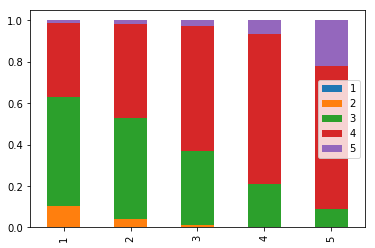

In [37]:
# correct category 3
#    predictions
#    rating = 5

def plot(predictions):
    data = np.zeros((5, 5), dtype=int)
    for rating in range(1, 6):
        correct = len(predictions[predictions[:, 1] == rating])

        #np.where(predictions[:, 1] == predictions[:, 0])
        #print(correct)
        p = []
        for i in range(1, 6):
            x = len(predictions[(predictions[:, 1] == rating) & (predictions[:, 0] == i)])
            data[(rating - 1, i - 1)] = x

    data = np.nan_to_num(data/data.sum(axis=1, keepdims=True))

    x = pd.DataFrame(data=data, index=range(1, 6), columns=range(1, 6))
    x.plot.bar(stacked=True)
    
plot(predictions)

In [20]:
def call_algo_svd(i):
    trainset, testset = i
    print("Run one split")
    # train and test algorithm.
    algo = SVDpp()
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    rmse = accuracy.rmse(predictions, verbose=True)
    return (algo, rmse)
        
def predict_svd():
    with Pool(10) as p:
        # define a cross-validation iterator
        kf = KFold(n_splits=10)
        return p.map(call_algo_svd, kf.split(data))

In [21]:
%%time
predictions_svd = predict_svd()
best_model_svd = min(predictions_svd, key=lambda b: b[1])

Run one split
Run one split
Run one split
Run one split
Run one split
Run one split
Run one split
Run one split
Run one split
Run one split
RMSE: 1.1048
RMSE: 1.0910
RMSE: 1.1109
RMSE: 1.0955
RMSE: 1.0983
RMSE: 1.1060
RMSE: 1.1181
RMSE: 1.0977
RMSE: 1.1019
RMSE: 1.0999
CPU times: user 3.84 s, sys: 665 ms, total: 4.5 s
Wall time: 1min 18s


In [19]:
x = do_predict(best_model_svd[0])

Lets train a linear regression to find the best coefficient

In [ ]:
#plot(x)
#plot(predictions)
#plot(x)
error = np.sqrt(mean_squared_error(x[:, 0], x[:, 1]))
error

In [ ]:
def combine(first, second):
    kf = KFold(n_splits=3)
    weights = []
    for trainset, testset in tqdm(kf.split(data), desc="split"):
        print("Do one split")
        input_for_linear = []
        for each in tqdm(trainset.all_ratings(), desc="Process rating of split"):
            pred1 = first.predict(str(each[0]), str(each[1])).est
            pred2 = second.predict(str(each[0]), str(each[1])).est
            output = [pred1, pred2]
            input_for_linear.append(output)
        
        y = list(map(lambda x: x[2], trainset.all_ratings()))
        eg = LinearRegression().fit(input_for_linear, y)
        
        predictions = []
        c = eg.coef_
        for i, b in enumerate(input_for_linear):
           # p = b[0] * c[0] + b[1] + c[1]
            p = b[0] * 0.5 + b[1] + 0.5
            predictions.append(p)
            
        error = np.sqrt(mean_squared_error(y, predictions))
        weights.append((error, c))
        
    return min(weights, key=lambda b: b[0])

In [ ]:
best_weights = combine(best_model_slope_one[0], best_model_svd[0])

In [ ]:
print(best_weights)

In [ ]:
print(best_weights)

In [ ]:
def create_submission_file(first, second, w1, w2):
    lines = read_txt('data/sample_submission.csv')[1:]
    data = [deal_line(line) for line in lines]

    predictions = []
    for each in tqdm(data):
        pred1 = first.predict(str(each[0]), str(each[1])).est
        pred2 = second.predict(str(each[0]), str(each[1])).est
        predictions.append((each[0], each[1], pred1 * w1 + pred2 * w2 ))

    with open('data/our_pred.csv', 'w') as f:
        f.write("Id,Prediction\n")
        for item in tqdm(predictions):
            f.write("r{}_c{},{}\n".format(item[0], item[1], int(round(item[2]))))

In [ ]:
create_submission_file(avd, algo)

In [ ]:
accuracy.rmse(algo, verbose=True)

### Blending implementations